In [42]:

import os
os.environ['KERAS_BACKEND'] = 'torch'

from IPython.display import clear_output
from typing import List
import torch
import keras
import xarray as xr
from src.EEGModalNet import WGAN_GP_old
from scipy.signal import butter, sosfiltfilt
import numpy as np
import pandas as pd
from sklearn.model_selection import GroupShuffleSplit
from sklearn.utils import class_weight
from keras import regularizers, layers

In [55]:
xr.open_dataarray('data/LEMON_DATA/EC_all_channels_processed_downsampled.nc5', engine='h5netcdf')


<xarray.DataArray (subject: 202, channel: 61, time: 47040)> Size: 5GB
[579626880 values with dtype=float64]
Coordinates:
  * subject  (subject) <U10 8kB 'sub-010002' 'sub-010003' ... 'sub-010321'
  * channel  (channel) <U4 976B 'Fp1' 'Fp2' 'F7' 'F3' ... 'POz' 'PO4' 'PO8'
Dimensions without coordinates: time
Attributes:
    gender:        [1 1 1 2 1 1 2 1 1 2 1 2 1 2 1 2 2 2 1 1 2 1 1 1 2 1 1 1 1...
    ch_positions:  [[0.3157684  0.9955463 ]\n [0.6865925  1.        ]\n [0.06...

In [43]:

def load_data(data_path: str,
              channels: List[str],
              n_subjects: int = 202,
              bandpass_filter: float = 1.0,
              time_dim: int = 1024,
              exclude_sub_ids=None) -> tuple:

    xarray = xr.open_dataarray(data_path, engine='h5netcdf')
    x = xarray.sel(subject=xarray.subject[:n_subjects], channel=channels)

    if exclude_sub_ids is not None:
        x = x.sel(subject=~x.subject.isin(exclude_sub_ids))

    x = x.to_numpy()
    n_subjects = x.shape[0]

    if bandpass_filter is not None:
        sos = butter(4, bandpass_filter, btype='high', fs=128, output='sos')  # TODO: fs
        x = sosfiltfilt(sos, x, axis=-1)

    # device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    x = torch.tensor(x.copy()).unfold(2, time_dim, time_dim).permute(0, 2, 3, 1).flatten(0, 1)  # TODO: copy was added because of an error, look into this

    sub = torch.tensor(np.arange(0, n_subjects).repeat(x.shape[0] // n_subjects)[:, np.newaxis])
    labels = xarray.gender - 1
    y = labels.repeat(x.shape[0] // 202)
    sub_ids_classifier = sub.squeeze().numpy()

    return x, y, sub_ids_classifier

In [44]:

channels = ['O1', 'O2', 'F1', 'F2', 'C1', 'C2', 'P1', 'P2']

X_input, y, groups = load_data('data/LEMON_DATA/EC_all_channels_processed_downsampled.nc5',
                                channels=channels,
                                n_subjects=202,
                                bandpass_filter=0.5,
                                time_dim=512,
                                exclude_sub_ids=None)


group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.3, random_state=2)
train_idx, val_idx = next(group_shuffle.split(X_input, y, groups=groups))
print('Chance level',
      np.unique(y[train_idx], return_counts=True)[1] / len(y[train_idx]),
      np.unique(y[val_idx], return_counts=True)[1] / len(y[val_idx]))

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights = {'0': class_weights[0], '1': class_weights[1]}

keras.utils.clear_session(free_memory=True)

model = WGAN_GP_old(time_dim=512, feature_dim=len(channels),
                    latent_dim=128, n_subjects=202,
                    use_sublayer_generator=True,
                    use_sublayer_critic=True,
                    use_channel_merger_g=False,
                    use_channel_merger_c=False,
                    interpolation='bilinear')

model.load_weights('logs/06022025/06.02.2025_epoch_2500.model.keras')

X_e = model.critic.model.get_layer('dis_flatten')(X_input)

X_input_subj = model.critic.get_layer('torch_module_wrapper_1')(
    X_input.float().to('mps'),
    torch.tensor(groups).to('mps'))
X_e_subj = model.critic.model.get_layer('dis_flatten')(X_input_subj)

Chance level [0.36879433 0.63120567] [0.36065574 0.63934426]


In [45]:
y_df = pd.DataFrame(y, columns=['y'])
y0_size = y_df.query('y==0').shape[0]
y1_sample_idx = y_df.query('y==1').sample(y0_size, random_state=1).index.values

resample_idx = np.concatenate([y_df.query('y==0').index.values, y1_sample_idx])

groups_resampled = groups[resample_idx]
X_e_resampled = X_e_subj[resample_idx].detach().cpu()
y_resampled = y[resample_idx]

# train/test split

from sklearn.model_selection import ShuffleSplit

random_shuffle = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)
train_idx, val_idx = next(random_shuffle.split(X_e_resampled, y_resampled))

# group_shuffle = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=2)
# train_idx, val_idx = next(group_shuffle.split(X_e_resampled, y_resampled, groups=groups_resampled))

y_resampled[train_idx].mean(), y_resampled[val_idx].mean()


(np.float64(0.5021347688880639), np.float64(0.4914625092798812))

In [46]:

def plot_history(history_df):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history_df['loss'], label='Train')
    plt.plot(history_df['val_loss'], label='Val')
    plt.legend()
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(history_df['accuracy'], label='Train')
    plt.plot(history_df['val_accuracy'], label='Val')
    plt.legend()
    plt.title('Accuracy')
    plt.show()

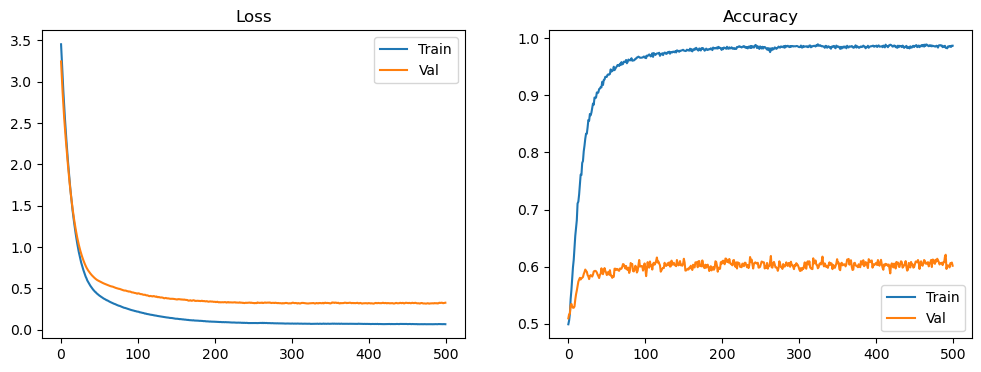

In [56]:
cls_model_path = 'logs/20.02.2025_classifier_v2'
callbacks = [
    keras.callbacks.ModelCheckpoint(f'{cls_model_path}.model.keras', monitor='val_accuracy', save_best_only=True),
    keras.callbacks.CSVLogger(f'{cls_model_path}.csv'),
    keras.callbacks.TerminateOnNaN()
]

cls_model = keras.models.Sequential([   
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.25),
    layers.Dense(32, activation='relu',
                 kernel_regularizer=regularizers.l2(0.01)),
    layers.Dropout(0.25),
    layers.Dense(1, activation='sigmoid')
])

def smoothed_binary_crossentropy(epsilon=0.1): # Epsilon controls smoothing
    def loss(y_true, y_pred):
        y_true_smoothed = y_true * (1.0 - epsilon) + 0.5 * epsilon # Soften labels
        return keras.losses.binary_crossentropy(y_true_smoothed, y_pred)
    return loss


cls_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    # loss='binary_crossentropy',
    # loss=keras.losses.Hinge(),
    # loss=smoothed_binary_crossentropy(),
    loss='mse',
    # loss=keras.losses.BinaryFocalCrossentropy(),
    metrics=['accuracy'])

history = cls_model.fit(
    X_e_resampled[train_idx], y_resampled[train_idx],
    epochs=500,
    batch_size=20000,
    validation_data=(X_e_resampled[val_idx], y_resampled[val_idx]),
    callbacks=callbacks,
    # class_weight=class_weights,
    shuffle=True)

history_df = pd.DataFrame(history.history)
history_df.to_csv(f'{cls_model_path}_final.csv')
cls_model.save(f'{cls_model_path}_final.model.keras')

clear_output(wait=True)
plot_history(history_df)